## Creating a Basic KAN

Now that we have linearized single-function evaluation, we can make a proper KAN

Reference code taken from https://github.com/pg2455/KAN-Tutorial/blob/main/2_stacked_splines.ipynb

Importing a few libraries...

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch

First let's make a basic [1,1] KAN

In [2]:
def extend_grid(grid, order):
    
    n_intervals = grid.shape[-1] - 1
    bucket_size = (grid[:, -1] - grid[:, 0]) / n_intervals

    #Add control points to grid, add the same number as the order to each side so that 
    #the interpolation can reference enough points to not lose resolution
    for i in range(order):
        grid = torch.cat([grid[:, :1] - bucket_size, grid], dim=-1)
        grid = torch.cat([grid, grid[:, -1:] + bucket_size], dim=-1)

    return grid

In [21]:
def eval_basis(x_eval, grid, order):
    
    grid_ = extend_grid(grid, order)
    #Adding extra dimensions for KAN training later
    grid_ = grid_.unsqueeze(dim=2)
    x_eval_ = x_eval.unsqueeze(dim=1)
    
    #Evaluating Cox-De Boor Recursion
    #Construct all bases of an order into a matrix, then move up, rather than explicitly recursing
    for i in range(order+1):
        if (i == 0):
            #Creating a matrix of basis value x_eval, rows are x_eval and columns are functions
            #Set bounds to stop it from going off the end
            bases = (x_eval_ >= grid_[:, :-1]) * (x_eval_ < grid_[:, 1:]) * 1.0 #Multiply by 1.0 to cast to float rather than bool
        else:
            #Bounds must shrink as order increases to ensure that adequate references (previous or subsequent nodes) exist
            bases1 = (x_eval_ - grid_[:, :-(i+1)]) / (grid_[:, 1:-i] - grid_[:, :-(i+1)]) * bases[:, :-1]
            bases2 = (grid_[:, (i+1):] - x_eval_) / (grid_[:, (i+1):] - grid_[:, 1:-i]) * bases[:, 1:]
            bases = bases1 + bases2

    return bases.transpose(1,2)

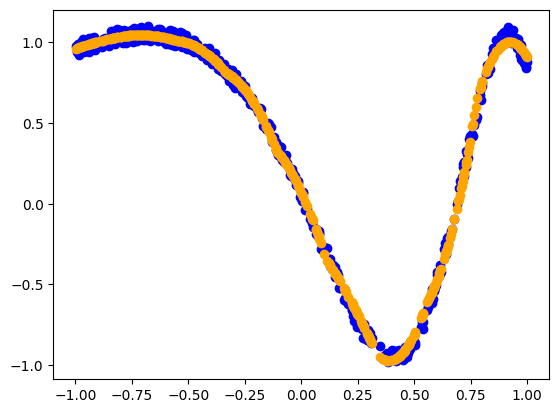

In [19]:
ctrl_pts = 10
order = 2
val_prct = 0.8
learn_rate = 0.1
fn = lambda x: torch.sin(torch.pi * torch.exp(x))

grid = torch.linspace(-1, 1, ctrl_pts).unsqueeze(dim=0)
x_eval = torch.linspace(-1, 1, steps=999).unsqueeze(dim=1)
#Create target set, give it some noise to be realistic
y_target = fn(x_eval) + 0.1 * torch.rand(x_eval.shape)
#Account for grid extension by increasing size by order-1
#No least squares this time, the gradient descent takes care of that
#Enabling gradient tracking via torch as well
coeffs = torch.zeros((1, ctrl_pts+order-1, 1), requires_grad=True)
#Establishing scaling parameters
base_transform_fn = torch.nn.SiLU()
scale_base = torch.nn.Parameter(torch.ones(x_eval.shape[-1])).requires_grad_(True)
scale_spline = torch.nn.Parameter(torch.ones(x_eval.shape[-1])).requires_grad_(True)

#Data structure for tracking training and validation losses
losses = {'train': [], 'test': []}

best_loss = np.inf
n_no_improvements = 0
iters = 0
all_xs = []
#Thresholds for stopping improvement
improvement_th = 200
iteration_th = 1e4

#Number of points to train with versus test
n_train = int(x_eval.shape[0] * 0.8)
#Select random indexes to reserve for training to reduce locality effects
train_idxs = np.random.randint(x_eval.shape[0], size=n_train)
#And get the rest into the test set
test_idxs = [i for i in range(x_eval.shape[0]) if i not in train_idxs]
x_train = x_eval[train_idxs]
x_test = x_eval[test_idxs]
y_train = y_target[train_idxs]
y_test = y_target[test_idxs]

while True:
    #Create an initial estimation based on the default coefficients
    x = x_train
    xs = []
    bases_train = eval_basis(x, grid, order)
    x_ = torch.einsum('ijk, bij->bk', coeffs, bases_train)
    x = (base_transform_fn(x)*scale_base) + (x_*scale_spline)
    xs.append(x.detach())
    all_xs.append(xs)

    #Compute gradients of estimation based on loss function
    y_pred_train = x
    loss = torch.mean(torch.pow(y_pred_train - y_train, 2))
    loss.backward()
    losses['train'].append(loss.item())

    #Gradient descent step for coefficients + scaling params
    #The torch autograd function tracks its gradient all the way to loss function
    for params in [coeffs, scale_base, scale_spline]:
        params.data = params.data - learn_rate * params.grad
        params.grad.zero_()

    #Use test set to see how close you are to minimum
    with torch.no_grad():
        x_v = x_test #v for validation, need something to distinguish it from previous x
        bases_test = eval_basis(x_v, grid, order)
        x_v_ = torch.einsum('ijk, bij->bk', coeffs, bases_test)
        x_v = (base_transform_fn(x_v)*scale_base) + (x_v_*scale_spline)
        y_pred_test = x_v
        test_loss = torch.mean(torch.pow(x_v - y_test, 2))
        losses['test'].append(test_loss.item())

    #Check if it found a minimum
    if best_loss > test_loss.item():
        best_loss = test_loss.item()
        best_coeffs = coeffs
        n_no_improvements = 0
    else:
        n_no_improvements += 1
        if n_no_improvements > improvement_th:
            break

    iters+=1
    if iters >= iteration_th:
        break

plt.scatter(x_test.tolist(), y_test.tolist(), color='blue')
plt.scatter(x_test.tolist(), y_pred_test.tolist(), color="orange")
plt.show()

Seems to work, now to scale this and turn it into a framework